In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
from scipy import stats

socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine

elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster

else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./package/")  # Since now we are in the Root Directory
from hapsburg.PackagesSupport.pp_individual_roh_csvs import post_process_roh_df, merge_called_blocks, individual_roh_statistic  # Import PP Functions
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
def merge_to_one_df(df1, df2, on="iid", min_snps=400000, max_age=1e6, only_inc_alt=True):
    """Merge Two Dataframes to one"""
    
    df_merge = pd.merge(df1, df2, on="iid")
    print(f"Merged to {len(df_merge)} Inds. (from {len(df1)} and {len(df2)}) resp.")
    
    ### Filter to High Coverage Individuals
    df_merge = df_merge[df_merge["n_cov_snp_x"] > min_snps]
    df_merge = df_merge[df_merge["age_x"] < max_age]
    if only_inc_alt:
        df_merge = df_merge[df_merge["include_alt_x"] > 0]
    print(f"Further filtered to {len(df_merge)} Individuals")
    return df_merge

def plot_correlation_roh(df_merge, xlim=[0,380], ylim=[0,380], savepath="", 
                         col1="sum_roh>4_y", col2="sum_roh>4_x", c_col="age_x", 
                         barlabel="Age [y BP]", figsize=(8,8), pad=20,
                         c_line="gray", lw=0.2, s=20, fs=14, fs_t=8, padax=4, 
                         vrange=[0.3,30], cmap="viridis", cb_pad=0.0,
                         cb_coords=[0.27, 0.8, 0.5, 0.05], pad_t1=4, 
                         tickwidth=2, ticklength=6, roh_bin=">4",
                         xlabel="Sum Full Readcount Data (cM)",
                         ylabel="Sum Pseudohaploid Data only (cM)"):
    """Plot correlation between ROH inferred on pseudo-haploid
    and on Readcount data. Print Pearson product-moment correlation coefficient"""
    r = np.corrcoef(df_merge[col1], df_merge[col2])[0,1]

    fig=plt.figure(figsize=figsize)
    ax=plt.gca()
    sc=ax.scatter(df_merge[col1], df_merge[col2], c=df_merge[c_col],
                  s=s, ec="k", lw=lw, zorder=1, norm=colors.Normalize(vmin=vrange[0], vmax=vrange[1]),
                  cmap=cmap) #LogNorm
    ax.plot(xlim, xlim, c=c_line, alpha=0.8, zorder=0)
    ax.set_xlabel(xlabel, fontsize=fs, labelpad=padax)
    ax.set_ylabel(ylabel, fontsize=fs, labelpad=padax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(labelsize=fs_t, width=tickwidth, length=ticklength, pad=pad_t1)
    text1=f"$r={r:.3f}$"
    text2=f"Inferred Sum ROH{roh_bin}cm \n for {len(df_merge)} HO individuals"
    ax.text(0.5, 0.02, text1, transform=ax.transAxes, fontsize=fs)
    ax.text(0.04, 0.87, text2, transform=ax.transAxes, fontsize=fs)
    
    # Do Colorbar Shennenigans
    cax = fig.add_axes(cb_coords)
    #fig.colorbar(im, cax=cax, orientation='horizontal')
    cb = fig.colorbar(sc, cax=cax, orientation='vertical', extend="max", pad=cb_pad)
    cb.ax.set_ylabel(barlabel, rotation=270, fontsize=fs, labelpad=pad)
    cb.ax.tick_params(labelsize=fs_t, direction="in")
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.tick_params(width=tickwidth, length=ticklength)
    
    if len(savepath)>0:
        plt.savefig(savepath, dpi=600) # bbox_inches = 'tight', pad_inches = 0
        print(f"Saved to {savepath}")
    plt.show()

# Analyze Long ROH in pseudo-haploid and diploid data

In [72]:
df_dip = pd.read_csv("./Empirical/HO/combined_roh_dip05.tsv", sep="\t")
df_hap = pd.read_csv("./Empirical/HO/combined_roh_hap05.tsv", sep="\t")
df_merge = merge_to_one_df(df_dip, df_hap, on="iid", min_snps=400000, only_inc_alt=False)

Merged to 599 Inds. (from 599 and 599) resp.
Further filtered to 599 Individuals


Saved to ./figures/manuscript/supplement/HO_ROH/HO_hap_dip.png


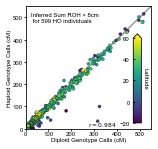

In [73]:
plot_correlation_roh(df_merge, xlim=[0,550], ylim=[0,550], c_col="lat_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Latitude", vrange=[-20,60],
                     cb_coords = [0.79, 0.16, 0.05, 0.55], tickwidth=0.8, roh_bin=" > 8",
                     ticklength=2, 
                     col1="sum_roh>8_x", col2="sum_roh>8_y", pad_t1=0.7,
                     xlabel="Diploid Genotype Calls (cM)",
                     ylabel="Haploid Genotype Calls (cM)",
                     savepath = "./figures/manuscript/supplement/HO_ROH/HO_hap_dip.png")

### Remove the Populations of the Outliers

In [7]:
df_dip = pd.read_csv("./Empirical/HO/combined_roh_dip05.tsv", sep="\t")
df_hap = pd.read_csv("./Empirical/HO/combined_roh_hap05.tsv", sep="\t")
df_merge = merge_to_one_df(df_dip, df_hap, on="iid", min_snps=400000, only_inc_alt=False)

Merged to 599 Inds. (from 599 and 599) resp.
Further filtered to 599 Individuals


In [8]:
pops_remove = ['Biaka','Ethiopian_Jew', 
               'Hadza', 'Ju_hoan_North',
               'Khomani', 'Mbuti', 'Somali']

In [9]:
idx = df_merge["pop_x"].str.contains("|".join(pops_remove))
print(f"Removing {np.sum(idx)} Individuals")
df_clean = df_merge[~idx].reset_index(drop=True)

Removing 25 Individuals


In [50]:
cm=8
diff = np.mean(df_clean[f"sum_roh>{cm}_y"] - df_clean[f"sum_roh>{cm}_x"])
mean = np.mean(df_clean[f"sum_roh>{cm}_y"])

print(f"Difference Haplotype - Diploid Calls: {diff:.2f} cM\nMean: {mean:.2f} cM")

Difference Haplotype - Diploid Calls: -0.53 cM
Mean: 97.50 cM


Saved to ./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean.png


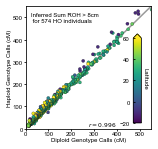

In [46]:
plot_correlation_roh(df_clean, xlim=[0,550], ylim=[0,550], c_col="lat_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Latitude", vrange=[-20,60],
                     cb_coords = [0.79, 0.16, 0.05, 0.55], tickwidth=0.8, roh_bin=" > 8",
                     ticklength=2, 
                     col1="sum_roh>4_x", col2="sum_roh>4_y", pad_t1=0.7,
                     xlabel="Diploid Genotype Calls (cM)",
                     ylabel="Haploid Genotype Calls (cM)",
                     savepath = "./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean.png")

# Results for bins

### 4-8 cM

In [65]:
df_t = df_clean.copy()
df_t["sum_roh_4-8_x"] = df_t["sum_roh>4_x"] - df_t["sum_roh>8_x"] 
df_t["sum_roh_4-8_y"] = df_t["sum_roh>4_y"] - df_t["sum_roh>8_y"] 

Saved to ./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_4_8.pdf


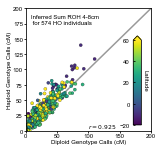

In [66]:
plot_correlation_roh(df_t, xlim=[0,200], ylim=[0,200], c_col="lat_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Latitude", vrange=[-20,60],
                     cb_coords = [0.79, 0.16, 0.05, 0.55], tickwidth=0.8, roh_bin=" 4-8",
                     ticklength=2, 
                     col1="sum_roh_4-8_x", col2="sum_roh_4-8_y", pad_t1=0.7,
                     xlabel="Diploid Genotype Calls (cM)",
                     ylabel="Haploid Genotype Calls (cM)",
                     savepath = "./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_4_8.pdf")

In [67]:
df_t["diff_4-8"] = df_t["sum_roh_4-8_y"] - df_t["sum_roh_4-8_x"]

### 8-20 cM

In [68]:
df_t = df_clean.copy()
df_t["sum_roh_8-20_x"] = df_t["sum_roh>8_x"] - df_t["sum_roh>20_x"] 
df_t["sum_roh_8-20_y"] = df_t["sum_roh>8_y"] - df_t["sum_roh>20_y"] 

Saved to ./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_8_20.pdf


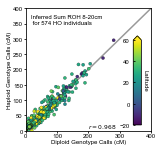

In [69]:
plot_correlation_roh(df_t, xlim=[0,400], ylim=[0,400], c_col="lat_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Latitude", vrange=[-20,60],
                     cb_coords = [0.79, 0.16, 0.05, 0.55], tickwidth=0.8, roh_bin=" 8-20",
                     ticklength=2, 
                     col1="sum_roh_8-20_x", col2="sum_roh_8-20_y", pad_t1=0.7,
                     xlabel="Diploid Genotype Calls (cM)",
                     ylabel="Haploid Genotype Calls (cM)",
                     savepath = "./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_8_20.pdf")

### >20 cm

In [70]:
df_t = df_clean.copy()

Saved to ./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_20.pdf


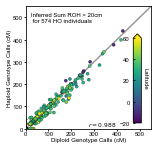

In [71]:
plot_correlation_roh(df_t, xlim=[0,550], ylim=[0,550], c_col="lat_x",padax=0.5,
                     lw=0.2, s=10, figsize=(2.25, 2.25), fs=6, fs_t=6, pad=6, cb_pad=-0.2,
                     barlabel="Latitude", vrange=[-20,60],
                     cb_coords = [0.79, 0.16, 0.05, 0.55], tickwidth=0.8, roh_bin=" > 20",
                     ticklength=2, 
                     col1="sum_roh>20_x", col2="sum_roh>20_y", pad_t1=0.7,
                     xlabel="Diploid Genotype Calls (cM)",
                     ylabel="Haploid Genotype Calls (cM)",
                     savepath = "./figures/manuscript/supplement/HO_ROH/HO_hap_dip_clean_20.pdf")

# Area 51

In [83]:
df_merge.columns

Index(['iid', 'pop_x', 'max_roh_x', 'sum_roh>4_x', 'n_roh>4_x', 'sum_roh>8_x',
       'n_roh>8_x', 'sum_roh>12_x', 'n_roh>12_x', 'sum_roh>20_x', 'n_roh>20_x',
       'label_x', 'lat_x', 'lon_x', 'x_contam_x', 'mt_contam_x', 'age_x',
       'study_x', 'clst_alt_x', 'period_alt_x', 'include_alt_x', 'clst_x',
       'mean_cov_x', 'med_cov_x', 'n_cov_snp_read_x', 'full_iid_x',
       'n_cov_snp_x', 'pop_y', 'max_roh_y', 'sum_roh>4_y', 'n_roh>4_y',
       'sum_roh>8_y', 'n_roh>8_y', 'sum_roh>12_y', 'n_roh>12_y',
       'sum_roh>20_y', 'n_roh>20_y', 'label_y', 'lat_y', 'lon_y', 'x_contam_y',
       'mt_contam_y', 'age_y', 'study_y', 'clst_alt_y', 'period_alt_y',
       'include_alt_y', 'clst_y', 'mean_cov_y', 'med_cov_y',
       'n_cov_snp_read_y', 'full_iid_y', 'n_cov_snp_y'],
      dtype='object')

In [155]:
cm=8
idx = (df_merge[f"sum_roh>{cm}_x"] - df_merge[f"sum_roh>{cm}_y"])/(df_merge[f"sum_roh>{cm}_x"]) > 0.5
#idx = (df_merge[f"max_roh_x"] - df_merge[f"max_roh_y"])/(df_merge[f"max_roh_x"]) > 0.5
df_fail = df_merge[idx]

In [156]:
fails = df_fail["pop_x"].value_counts()
tot_counts = df_merge["pop_x"].value_counts()
t1 = tot_counts[fails.index]

In [157]:
df_stat = pd.DataFrame({"failed":fails, "count":t1})

In [160]:
print(df_stat.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  failed &  count \\
\midrule
Ju\_hoan\_North &       4 &      4 \\
Hadza         &       3 &      3 \\
Mbuti         &       3 &      4 \\
Khomani       &       3 &      3 \\
Biaka         &       2 &      3 \\
Ethiopian\_Jew &       1 &      2 \\
Somali        &       1 &      6 \\
\bottomrule
\end{tabular}



### df_merge[df_merge[f"sum_roh>{cm}_x"] - df_merge[f"sum_roh>{cm}_y"]>40]